# Analysis of Diffraction Grating Measurements
Written by: Taylor Contreras, March 10 2021

This analysis assumes data is output from the DiffractionStudy_Automation.ipynb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal
from math import atan, pi
import pandas as pd

In [10]:
import os
current_path = os.getcwd()
current_path

'C:\\Users\\Owner\\Documents\\DiffractionStudies\\metalens'

In [6]:
# Get the data
file_name ='run004_distilled_water_data_50ns_15sweeps_airgap.csv'

with open(file_name) as file:
    reader = csv.reader(file)
    i = 0
    for row in reader:
        if i==2:
            WithGrating_pos_led = float(row[0])
            
        if i==4:
            WithGrating_pos_sipm = np.array([float(row[j]) for j in range(len(row))])
            
        if i==6:
            WithGrating_voltage = np.array([float(row[j]) for j in range(len(row))])
            
        if i==10:
            BelowGrating_pos_led = float(row[0])
            
        if i==12:
            BelowGrating_pos_sipm = np.array([float(row[j]) for j in range(len(row))])
        
        if i==14:
            BelowGrating_voltage = np.array([float(row[j]) for j in range(len(row))])
            
        if i==16:
            GRATING_LED_POSITION = float(row[1])
        
        if i==18:
            BELOW_GRATING_LED_POSITION = float(row[1])
        
        if i==20:
            BELOW_MOUNT_LED_POSITION = float(row[1])
            
        if i==22:
            VOLTAGE = float(row[1])
        
        i+= 1
    

FileNotFoundError: [Errno 2] No such file or directory: 'run004_distilled_water_data_50ns_15sweeps_airgap.csv'

In [55]:
def ledVoltage_to_sipmPeak(led_V):
    """
    Returns the correct SiPM peak voltage
    based on the LED voltage, to correct
    for sipm saturation. This fit was found
    in the Linearity_Analysis.ipynb using
    a 50ns pulse width. 
    """
    m = 0.014264022538903087
    b = -0.026668937550506203
    
    if led_V < 2.0:
        return 0.0
    
    return m*led_V + b

def corrected_sipm_peaks(sipm_peaks):
    look_up_table = pd.read_csv('sipm_linearity_lookup_table.csv')
    
    led_voltages = np.interp(sipm_peaks, look_up_table.V_sipm, look_up_table.V_led)

    corrected_peaks = []
    for i in range(len(sipm_peaks)):
        if sipm_peaks[i] < 0.025:
            corrected_peaks.append(sipm_peaks[i])
        else:
            corrected_peaks.append(ledVoltage_to_sipmPeak(led_voltages[i]))
        
    return corrected_peaks

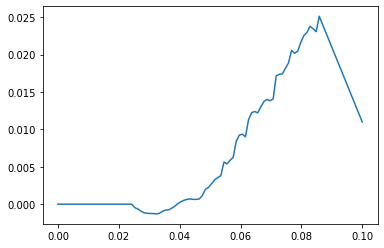

In [56]:
# peak height versus correction
peaks = np.linspace(0.0,0.1, 100)
corrected_peaks = corrected_sipm_peaks(peaks)
corrections = corrected_peaks - peaks
plt.plot(peaks, corrections)

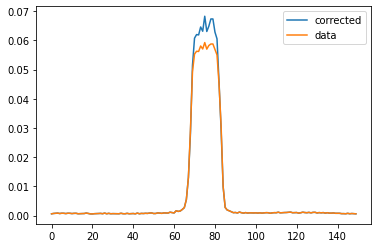

In [57]:
cc_BelowGrating_voltage = corrected_sipm_peaks(BelowGrating_voltage)
plt.plot(cc_BelowGrating_voltage,label='corrected')
plt.plot(BelowGrating_voltage, label='data')
plt.legend() 

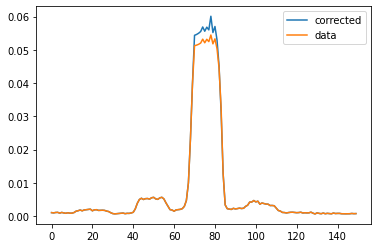

In [58]:
cc_WithGrating_voltage = corrected_sipm_peaks(WithGrating_voltage)
plt.plot(cc_WithGrating_voltage,label='corrected')
plt.plot(WithGrating_voltage, label='data')
plt.legend()

Text(0.5, 0, 'SiPM Position [mm]')

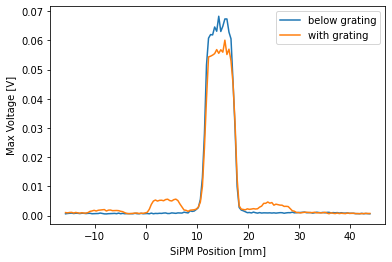

In [59]:
halfway = len(WithGrating_pos_sipm)//2
plt.plot(np.array(BelowGrating_pos_sipm)-BELOW_GRATING_LED_POSITION, cc_BelowGrating_voltage, label='below grating')
plt.plot(np.array(WithGrating_pos_sipm)-GRATING_LED_POSITION, cc_WithGrating_voltage, label='with grating')
#plt.plot(np.array(BelowMount_pos_sipm)-BELOW_MOUNT_LED_POSITION, BelowMount_voltage, label='below mount')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

In [60]:
# Light Collection efficiency of peaks
eff_bg = max(WithGrating_voltage)/max(BelowGrating_voltage)
#eff_bm = max(WithGrating_voltage)/max(BelowMount_voltage)
print('Light collection efficiency (Grating/Below Grating) = ' + str(round(eff_bg,4)*100)+'%')
#print('Light collection efficiency (Grating/Below Mount) = ' + str(round(eff_bm,4)*100)+'%')

Light collection efficiency (Grating/Below Grating) = 91.86%


In [61]:
# Find the peak and the peak position when not using the grating
BelowGrating_corrected_pos_sipm = np.array(BelowGrating_pos_sipm)-BELOW_GRATING_LED_POSITION
WithGrating_corrected_pos_sipm = np.array(WithGrating_pos_sipm)-GRATING_LED_POSITION

BelowGrating_peaks, _ = signal.find_peaks(cc_BelowGrating_voltage, prominence=0.01)
BelowGrating_widths = signal.peak_widths(cc_BelowGrating_voltage, BelowGrating_peaks)

l = BelowGrating_corrected_pos_sipm[int(BelowGrating_widths[2][0])]
r = BelowGrating_corrected_pos_sipm[int(BelowGrating_widths[3][0])]
BelowGrating_peak_pos = (r + l)/2
print('Position of peak below diffraction grating: '+str(round(BelowGrating_peak_pos,3)))

Position of peak below diffraction grating: 14.255


In [74]:
# Find the peaks and their widths with a large prominence
peaks, _ = signal.find_peaks(cc_WithGrating_voltage, prominence=0.002, distance=10)
print('Peak positions',WithGrating_corrected_pos_sipm[peaks], peaks)
print('Peak heights', )
widths = signal.peak_widths(cc_WithGrating_voltage, peaks)
# The widths includes the position of the FWHM left and right bins
# Use these to calculate the position of the peak
l1 = WithGrating_corrected_pos_sipm[int(widths[2][0])]
r1 = WithGrating_corrected_pos_sipm[int(widths[3][0])]
peak1_pos = (r1 + l1)/2.

l2 = WithGrating_corrected_pos_sipm[int(widths[2][1])]
r2 = WithGrating_corrected_pos_sipm[int(widths[3][1])]
peak2_pos = (r2 + l2)/2.
  
dist_between_peaks = abs(peak2_pos - peak1_pos)

Peak positions [ 5.855 15.455 23.855] [54 78 99]
Peak heights


In [72]:
print(sum([WithGrating_voltage[i] for i in peaks]))
print(max(BelowGrating_voltage))
print(max(WithGrating_voltage))

0.06682957720056497
0.0592687498826763
0.0544436211941957


In [75]:
print(sum([cc_WithGrating_voltage[i] for i in peaks]))
print(max(cc_BelowGrating_voltage))
print(max(cc_WithGrating_voltage))

0.07040068429225378
0.06828703167371443
0.06008484753110245


In [73]:
print(cc_WithGrating_voltage[peaks[0]]+cc_WithGrating_voltage[peaks[1]]+cc_WithGrating_voltage[peaks[2]])
print(max(cc_BelowGrating_voltage))

0.06780144874741857
0.06828703167371443


In [71]:
# Calculate the angle or refraction
x =  66.4#37.5 # (36.4 + 35.6)/2. # distance between sipm and lens
theta = atan(dist_between_peaks/x)

# Convert to degrees
print("The angle of refraction is "+str(round(theta*360/(2*pi),2))+', theoretical: 12.16')

The angle of refraction is 9.18, theoretical: 12.16


In [18]:
# Light Collection efficiency summed peaks
eff = (sum([WithGrating_voltage[i] for i in peaks]))/max(BelowGrating_voltage)
print('Light collection efficiency summing peaks (Grating/below grating) = ' + str(round(eff,4)*100)+'%')

eff = (sum([WithGrating_voltage[i] for i in peaks]))/max(BelowMount_voltage)
print('Light collection efficiency summing peaks (Grating/below mount) = ' + str(round(eff,4)*100)+'%')

SyntaxError: invalid syntax (<ipython-input-18-0605c4e1081c>, line 2)